# Movie Data Analysis

### Business Problem 
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

## Business Understanding

In order to generate actionable insights for this stakeholder, we are inspecting several data sets containing film information.  


### Sources:  
-[Box Office Mojo](https://www.boxofficemojo.com/)  
-[IMDB](https://www.imdb.com/)  
-[Rotten Tomatoes](https://www.rottentomatoes.com/)  
-[The Movie DB](https://www.themoviedb.org/)  
-[The Numbers](https://www.the-numbers.com/)   

### Topics to address:  
- Which producers create the best films?  
    - Criteria for analysis:  
        - Production budget vs. gross income
        - Mean of film (review) ratings over time
        - Success of particular genres of films per producer
        
- Which film genres are most successful in theaters?  
    - Criteria for analysis:  
        - Gross income of particular genres of films  
        - The associated production costs of particular genres
        - Success of particular film (classification) ratings  
        
- Is there a season during which film releases fare better?  
    - Criteria for analysis:  
        - Frequency of films being released over quarters and months  
        - Gross income of films grouped over quarters and months  
        - Production costs for films being released during the most profitable months

### Possible measurements of success:  
- Net income: gross income minus production budget
- Worldwide gross income
- Viewership numbers
- Film ratings

### 

## Data Preparation

In [2]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import copy
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
basics_names = pd.read_csv("zippedData/imdb.name.basics.csv")
#Nconst, Primary Name, Primary Profession, Known for titles(title_id)
#just producers
ratings = pd.read_csv("zippedData/imdb.title.ratings.csv")
#Tconst, Average Rating, Number of Votes
movies_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
#Titles, Studio, Domestic Gross, Foreign Gross and Year
basics_titles = pd.read_csv("zippedData/imdb.title.basics.csv")
#Tconst, Primary Title, Original Title, Start Year, Runtime Minutes, Genres
movies_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv")
movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv")
#Id, Release Date, Movie Name, Production Budget, Domestic Gross, Worldwide Gross
movies = pd.read_csv("zippedData/tmdb.movies.csv")
#Genre Id, Id, Original Language, Original Language, Original Title, Popularity, Release Date, Title, Vote Average, Vote count

FileNotFoundError: [Errno 2] No such file or directory: 'zippedData/imdb.name.basics.csv'

# Working with data

### Working with the basics_titles dataframe

Creating a table that contains Titles, Genres, Start Year and Tconst.

In [5]:
# Clean basics_titles to only those released after 2008 and before 2020
# Clean NAN rows, since they didn't have the most important information for this analysis, the genre
# Drop the columns

basics_titles = basics_titles[basics_titles['start_year'] > 2008]
basics_titles = basics_titles[basics_titles['start_year'] <= 2019]
title_genre = basics_titles.drop(['original_title', 'runtime_minutes'], axis=1)
title_genre.dropna(inplace=True)

In [6]:
title_genre.head(2)

,tconst,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"


Creating a new table with the rating, tconst, primary_title and genre.

In [7]:
# Join tables to create a new one with more info
# Drop NAN values, since they didn't have the most important information for this analysis, the genre

titlegenrerating = ratings.join(title_genre.set_index('tconst'), on='tconst')
titlegenrerating.dropna(inplace=True)
titlegenrerating.rename(columns={"start_year": "release_year"}, inplace=True)

In [8]:
titlegenrerating.head(2)

,tconst,averagerating,numvotes,primary_title,release_year,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,2019.0,Romance
1,tt10384606,8.9,559,Borderless,2019.0,Documentary


# Working with the movies_budgets dataframe

The goal here is to create a table with Movies Name, Budget, Domestic Gross and Worldwide Gross(Cleaning the column ID)

In [9]:
# Drop columns that we are not going to use
# Rename Column to match the other table, to make left-join possible

movies_money = movies_budgets.drop(['id', 'release_date'], axis=1)
movies_money.rename(columns={"movie": "primary_title"}, inplace=True)

In [10]:
#5782 rows
movies_money.head(2)

,primary_title,production_budget,domestic_gross,worldwide_gross
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [11]:
# Using method str.replace to remove ',' and '$' from the data columns 
# Using astype to change the values in those columns from String to Float because to Int gives an error

movies_money['worldwide_gross'] = movies_money['worldwide_gross'].str.replace(',', '')
movies_money['worldwide_gross'] = movies_money['worldwide_gross'].str.replace('$', '')
movies_money['worldwide_gross'] = movies_money['worldwide_gross'].astype(float)

movies_money['production_budget'] = movies_money['production_budget'].str.replace(',', '')
movies_money['production_budget'] = movies_money['production_budget'].str.replace('$', '')
movies_money['production_budget'] = movies_money['production_budget'].astype(float)

movies_money['domestic_gross'] = movies_money['domestic_gross'].str.replace(',', '')
movies_money['domestic_gross'] = movies_money['domestic_gross'].str.replace('$', '')
movies_money['domestic_gross'] = movies_money['domestic_gross'].astype(float)


In [12]:
# Create a new column to give the investment return (How many dollars you get per dollar invested)
# Check for duplicated entries on the data based on the primary title column q
# Drop all the duplicates, not keeping any so it doesn't conflict with the other table and we get false information

movies_money['investment_return'] = movies_money['worldwide_gross']/movies_money['production_budget'] -1 

duplicates_money = movies_money[movies_money.duplicated(subset=['primary_title'],keep=False)].sort_values(['primary_title'])

movies_money.drop_duplicates(subset='primary_title', inplace=True)

In [13]:
movies_money.head(2)

,primary_title,production_budget,domestic_gross,worldwide_gross,investment_return
0,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673


# Creating the new table moviesfullinfo

The idea here is to join two tables to make one with ratings and money to make mostly a correlation between these 2 metrics

In [14]:
# Drop Tconst, since this one is supposed to be the final table to use for graphs
# Drop nan's values
# Creat a filter to only movies that had a budget over a million dollars

moviesfullinfo = movies_money.join(titlegenrerating.set_index('primary_title'), on='primary_title')
moviesfullinfo.drop(['tconst', 'numvotes', 'domestic_gross'], axis=1, inplace=True)
moviesfullinfo = moviesfullinfo.dropna()
moviesfullinfo = moviesfullinfo[moviesfullinfo['production_budget'] >= 1000000]
moviesfullinfo = moviesfullinfo[moviesfullinfo['worldwide_gross'] >= 1]
moviesfullinfo.drop_duplicates(subset='primary_title', inplace=True)

In [15]:
#2410 rows

moviesfullinfo.sort_values(['investment_return'], ascending=False).head(2)

,primary_title,production_budget,worldwide_gross,investment_return,averagerating,release_year,genres
5210,Rocky,1000000.0,225000000.0,224.00000,6.1,2013.0,"Action,Comedy,Drama"
5211,The Devil Inside,1000000.0,101759490.0,100.75949,4.2,2012.0,Horror


# Creating the new table movieswoutratings

Here the goal was to make a table to make a correlation between Genre, Production, Worldwide Gross, Domestic Gross and ROI's

In [16]:
# Clean any NAN values
# Create filter to production budget over 1 million dollars
# Create filter where the movie made at least 1 dollar (Excluding movies from streaming services)

movieswoutratings = moviesfullinfo.dropna()
movieswoutratings = movieswoutratings[movieswoutratings['production_budget'] >= 1000000]
movieswoutratings = movieswoutratings[movieswoutratings['worldwide_gross'] >= 1]

In [17]:
#3392 rows
movieswoutratings.head(3)

,primary_title,production_budget,worldwide_gross,investment_return,averagerating,release_year,genres
0,Avatar,425000000.0,2.776345e+09,5.532577,6.1,2011.0,Horror
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,1.546673,6.6,2011.0,"Action,Adventure,Fantasy"
2,Dark Phoenix,350000000.0,1.497624e+08,-0.572108,6.0,2019.0,"Action,Adventure,Sci-Fi"


# Making tables for each genre

>Made a list with all the genres in it!

In [18]:
listatest = []
generos = "Action, Adventure, Animation, Biography, Crime, Documentary, Drama, Family, Fantasy, History, Horror, Music, Musical, Mystery, Romance, Sci-fi, Sport, Thriller, War, Western"
listatest.append(generos.split(", "))
listatest = listatest[0]

In [19]:
listatest[15]

'Sci-fi'

>Created a table for each genre, so it's easier to see and manipulate

In [20]:
def get_df_genre(genre):
    '''
    This function gets a dataset based on the Genre, with the average rating attached to it
    '''
    return titlegenrerating[titlegenrerating['genres'].str.contains(genre.title().strip())]

In [21]:
genre_rating_df = []
for genre in listatest:
    genre_rating_df.append(get_df_genre(genre))
    

In [22]:
genre_rating_df[-1].head(1)

,tconst,averagerating,numvotes,primary_title,release_year,genres
857,tt1578709,4.3,323,Snowblind,2010.0,Western


>And here we create a table for each genre with important info attached, but for that we had to lose some rows.

In [23]:
def get_df_genre(genre):
    '''
    This function gets a dataset based on the Genre, with information
    like production buddget and worldwide gross attached to it.
    '''
    return moviesfullinfo[moviesfullinfo['genres'].str.contains(genre.title().strip())]

In [24]:
all_genre_df = []
for genre in listatest:
    all_genre_df.append(get_df_genre(genre))
    

In [25]:
all_genre_df[-1].head(2)

,primary_title,production_budget,worldwide_gross,investment_return,averagerating,release_year,genres
12,The Lone Ranger,275000000.0,260002115.0,-0.054538,6.4,2013.0,"Action,Adventure,Western"
368,Django Unchained,100000000.0,449948323.0,3.499483,8.4,2012.0,"Drama,Western"


>And now we want the average rating based on the genre! Is there one that is more likely to be acclaimed by critics?

Getting the average RATING per Genre

In [26]:
def avg_rating_genre(dataframe):
    '''
    This function gets the avarage(mean) rating based on the Genre
    '''
    return(dataframe['averagerating'].mean())

In [27]:
avg_rating_per_genre = []
for rating in genre_rating_df:
    avg_rating_per_genre.append(avg_rating_genre(rating))

In [28]:
avg_rating_per_genre[11]

6.9305219364599155

**Getting the average RETURN ON INVESTMENT per Genre**

In [29]:
def avg_roi_genre(dataframe):
    '''
    This function gets the ROI based on the Genre
    '''
    worldgross = sum(dataframe['worldwide_gross'])
    prodbudget = sum(dataframe['production_budget'])
    print(prodbudget)
    return (worldgross/prodbudget-1)*100

In [30]:
avg_roi_per_genre = []
for genre_df in all_genre_df:
    avg_roi_per_genre.append(avg_roi_genre(genre_df))

36326800000.0
37819883106.0
10473500000.0
4057043106.0
7969850000.0
2317743106.0
24955865023.0
6705700000.0
10687200000.0
1589900000.0
4426210000.0
1473550000.0
505900000.0
3772855023.0
4792790000.0
13037657373.0
1118700000.0
10080797650.0
658300000.0
595500000.0


In [31]:
avg_roi_per_genre[1]

230.94281992940222

# Data Visualization
## Rating per genre
- How likely is to have a better rating with the critics if your movie is a certain genre?

> **To answer that we use "genre_rating_df" table that we prepared for this topic!**

In [32]:
df1 = pd.DataFrame({"Avg. Rating":avg_rating_per_genre, "Genres":listatest})

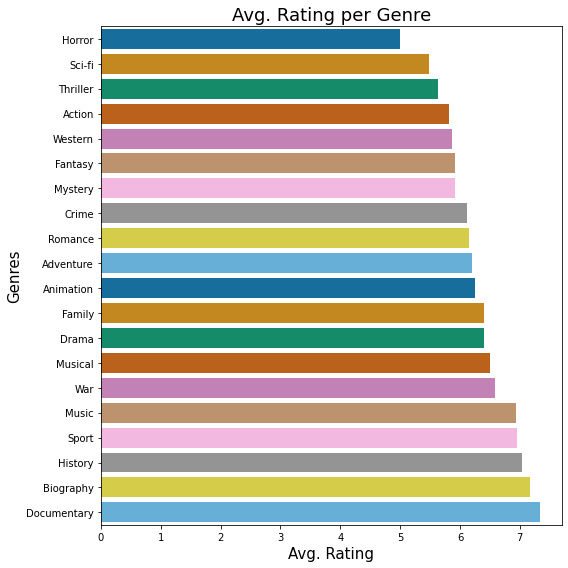

In [33]:
plt.figure(figsize=(8,8))
sns.barplot(x="Avg. Rating", y = "Genres", palette='colorblind', data=df1, errcolor='.95', order=df1.sort_values("Avg. Rating").Genres)
plt.xlabel("Avg. Rating", size=15)
plt.ylabel("Genres", size=15)
plt.title("Avg. Rating per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

## Money per genre
- What is the best genre solely focused on how much money you can make?
- What genre is the "safest choice"? Less likely to lose money?
- What genre takes the least money to produce? And the most?


### - What is the best genre solely focused on how much money you can make?

In [34]:
df = pd.DataFrame({"ROI":avg_roi_per_genre, "Genres":listatest})

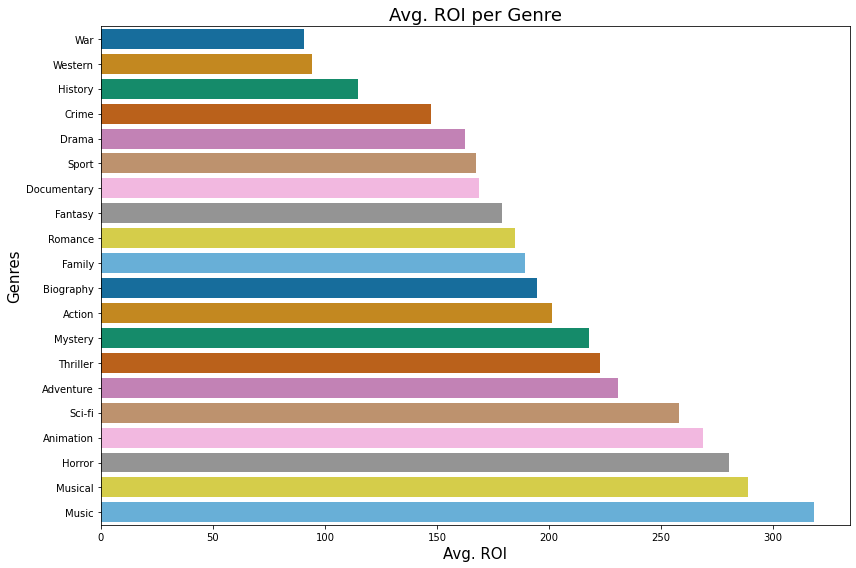

In [35]:
plt.figure(figsize=(12,8))
sns.barplot(x="ROI", y = "Genres", palette=('colorblind'),data=df, order=df.sort_values('ROI').Genres)
plt.xlabel("Avg. ROI", size=15)
plt.ylabel("Genres", size=15)
plt.title("Avg. ROI per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

The answer? Music, Musical and Horror!

### - What genre is the safest choice?

So we are going to create a list that gives you a percentage of how likely you are to make or to lose money using the number of positive ROI's and the number of negative ROI's.

In [36]:
def how_safe(dataframe):
    '''
    This function gets the avarage(mean) rating based on the Genre
    '''
    positive_count = None
    negative_count = None
    if (dataframe['investment_return'] >= 0).bool():
        positive_count += 1
        total_count += 1
    else:
        total_count += 1
    
    return(positive_count/total_count)

In [37]:
roi_list = []
for roi in all_genre_df:
    roi_list.append(roi['investment_return'])

In [38]:
positive_value = 0
total_value = 0
for x in roi_list[19]:
    if x > 0:
        positive_value += 1
        total_value += 1
    else:
        total_value += 1
print(positive_value/total_value)

0.4


In [39]:
chance_of_doing_well = [0.7368421052631579, 0.8174807197943444, 0.8632478632478633, 0.630057803468208, 0.6073825503355704, 0.6785714285714286, 0.6232006773920407, 0.7876106194690266, 0.7910447761194029, 0.5909090909090909, 0.6846153846153846, 0.6301369863013698, 0.4, 0.7159763313609467, 0.6814814814814815, 0.7375, 0.6041666666666666, 0.6675324675324675, 0.43, 0.38461538461538464]

In [40]:
chance_profitability = []
for x in chance_of_doing_well:
        chance_profitability.append(x*100)

In [41]:
chance_profitability[2]

86.32478632478633

In [42]:
chance_loss = []
for loss in chance_profitability:
    chance_loss.append(100-loss)

In [43]:
chance_loss[1]

18.251928020565558

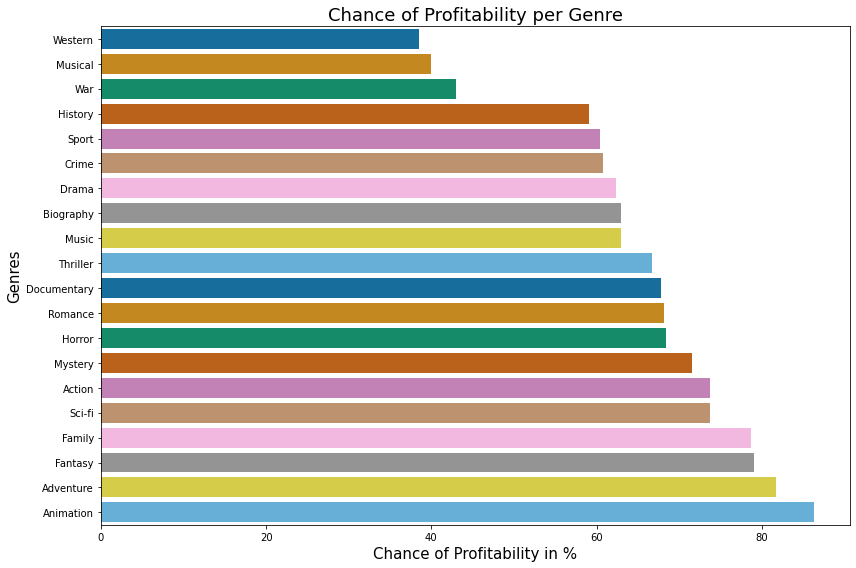

In [45]:
df2 = pd.DataFrame({"Chances":chance_profitability, "Genres":listatest})

plt.figure(figsize=(12,8))
sns.barplot(x="Chances", y = "Genres",data=df2, palette='colorblind', order=df2.sort_values('Chances').Genres)
plt.xlabel("Chance of Profitability in %", size=15)
plt.ylabel("Genres", size=15)
plt.title("Chance of Profitability per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

<AxesSubplot:title={'center':'Chance of Profitability per Genre'}, ylabel='Genre'>

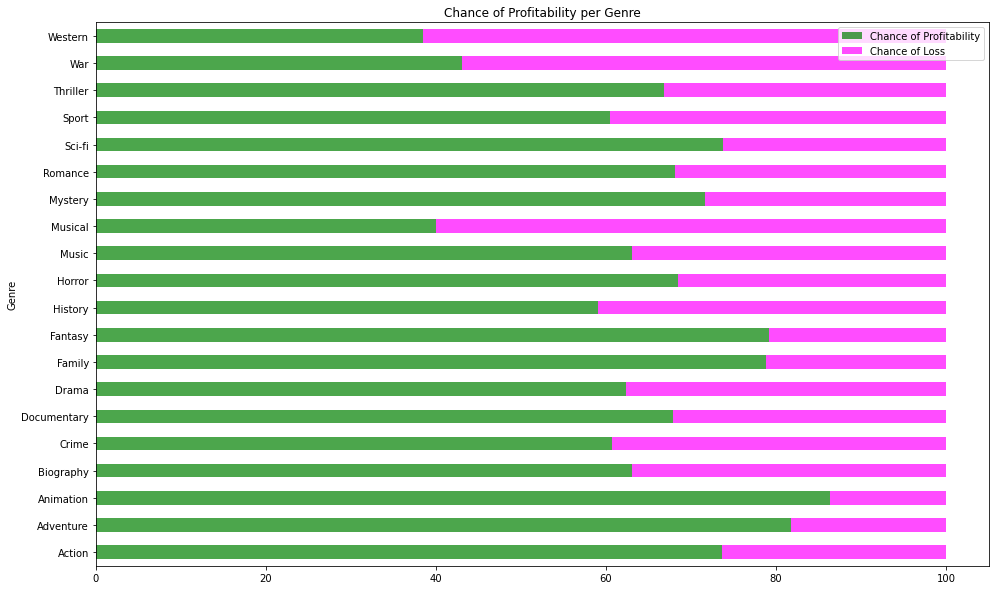

In [48]:
df3 = pd.DataFrame(list(zip(chance_profitability, chance_loss, listatest)), columns =['Chance of Profitability', 'Chance of Loss', 'Genre'])
                   
colors = ['green', 'magenta']
df3.plot( 
    x = 'Genre', 
    kind = 'barh', 
    stacked = True, 
    title = 'Chance of Profitability per Genre',
    mark_right = True,
    color = colors,
    alpha = 0.7,
    figsize=(16,10)) 

## RACHEL

## Data Understanding

# Trimming Down Data
I poked around in the data some more and found a way to link the four big dataframes with all the information I neeeded by merging on their shared content, dropping unused columns, data cleaning, and renaming columns for clarity. I kept a record of the number of columns and rows to asee how much data I lost and make sure it was only things I meant to lose
 My four data frames I used were:
 Basics_names, basics_titles, ratings, movie_budgets

In [1]:
producer = (basics_names.loc[basics_names['primary_profession'] == 'producer'])
#finds only information where the primary profession is equal to producer
#save that data frame in in variable called producer 

producer = producer[producer['known_for_titles'].notna()]
#filters out every NAN in the known for titles column
#only wnat producers who have worked on product
#21492 rows × 6 columns

producer_condensed = producer[['primary_name', 'known_for_titles']]
#condenses down the dataframe to just the infor I want, the two columns with name and titles
#21492 rows × 2 columns

producer_condensed = producer_condensed.rename(columns={'primary_name' : 'producer_name', 'known_for_titles' : 'all_title_ids_unsplit'})
#rename columns for ease of understanding
#21492 rows × 2 columns

producer_condensed['title_id_split']=producer_condensed['all_title_ids_unsplit'].map(lambda x : x.split(','))
#takes the list that contains a single string of comma separated values and separates them so they are iterable
#21492 rows × 3 columns

producer_name_split_title_ids = producer_condensed[['producer_name', 'title_id_split']]
#drops unusable column of unsplit tile ids
#21492 rows × 2 columns

#producer
#producer_condensed
producer_name_split_title_ids

NameError: name 'basics_names' is not defined

## Evaluation  

### Recommendations for Film Producers  
-  

### Recommendations for Genres of Films  
-

### Recommendations for Release Dates  
-


## Conclusion